Effect of water gas shift reaction   
All calculations are done for the production of 1 mol of Fe   
Enthalpy values have been calculated from NIST-JANAF Thermochemical Tables   

FewO+H2 = w Fe+ H2O   Eq. 6  
FewO+CO = w Fe+ CO    Eq. 6  
xCO≥(1+1/KwCO)/w*(1-beta)  Eq. 4  
jetaH2≥(1+1/KwH2)/w*beta   Eq. 5  
w/(4w-3)Fe3O4+H2=w/(4w-3)FewO+H2O  Eq. 7  
w/(4w-3)Fe3O4+CO=w/(4w-3)FewO+CO2  Eq. 7  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots as sp
import matplotlib.cm as cm
import os
import math
import ast
from sympy import symbols, Eq, solve
from scipy.optimize import fsolve
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [2]:
# Calculation of alpha according to Eq. 6
def alpha(x_ratio,T):
    value1=H2_FewO_Fe(T)*x_ratio*(1+CO_FewO_Fe(T))/((1+H2_FewO_Fe(T))*\
                                                    (1-x_ratio)*CO_FewO_Fe(T))
    value = value1/(1+value1)
    return value

In [3]:
# Calculation according to Eq. 4
def xCO(x_ratio,T,w):
    value1=(1+1/CO_FewO_Fe(T))/w*(1-alpha(x_ratio,T))
    return value1

In [4]:
# Calculation according to Eq. 5
def jietaH2(x_ratio,T,w):
    value1=(1+1/H2_FewO_Fe(T))/w*alpha(x_ratio,T)
    
    return value1

In [5]:
#Calculation according to Eq. 9 
def rCO(x_CO, alpha, w):
    value=x_CO-(1-alpha(x_ratio,T))/w
    #print('rCO:', value)
    return value

def fCO(x_CO,alpha, w,jieta_H2,T,pusai_H2):
    return rCO(x_CO, alpha, w)-\
    (1-beta(jieta_H2,x_CO, alpha, w,T,pusai_H2))\
    *(4*w-3)/(3*w)

def aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2):
    return fCO(x_CO, alpha, w,jieta_H2,T,pusai_H2)-\
    (1-gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2))/6

In [6]:
#Calculation according to Eq. 10
def tCO2( alpha, w):
    value=(1-alpha(x_ratio,T))/w
    #print('tCO2:', value)
    return value
def gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return tCO2( alpha, w)+\
    (1-beta(jieta_H2,x_CO, alpha, w,T,pusai_H2))*\
     (4*w-3)/(3*w)

def bCO2(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
    (1-gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2))/6

In [7]:
#Calculation according to Eq. 12 
def uH2(jieta_H2, alpha, w,pusai_H2):
    value = jieta_H2 + pusai_H2  - alpha(x_ratio,T) / w
    #print('uH2:', value)
    return value
def jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return uH2(jieta_H2, alpha, w,pusai_H2)-\
           beta(jieta_H2,x_CO, alpha, w,T,pusai_H2)*\
            (4*w-3)/(3*w)

def dH2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)-\
           gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2)/6

In [8]:
#Calculation according to Eq. 12 
def vH2O(alpha, w):
    value=alpha(x_ratio,T)/w
    #print('vH2O:', value)
    return value
def mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return vH2O(alpha, w)+\
           beta(jieta_H2,x_CO, alpha, w,T,pusai_H2)*\
           (4*w-3)/(3*w)

def eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return mH2O(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
    gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2)/6

In [9]:
#Calculation of beta according to Eq. 7
def beta(jieta_H2,x_CO, alpha, w,T,pusai_H2):
    H2solution=(uH2(jieta_H2, alpha, w,pusai_H2)*H2_Fe3O4_FewO(T)-vH2O(alpha, w))/(1+H2_Fe3O4_FewO(T))
    COsolution=(rCO(x_CO,alpha, w)*CO_Fe3O4_FewO(T)-tCO2(alpha, w))/(1+CO_Fe3O4_FewO(T))
    value=H2solution/(H2solution+COsolution)
    return value

In [10]:
#Calculation according to Eq. 8
def gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
           (jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
            fCO(x_CO,alpha, w,jieta_H2,T,pusai_H2))

In [11]:
def CO_FewO_Fe(T):
    lgK=logKf("CO2", T+273.15) - logKf("FewO", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K
def CO_Fe3O4_FewO(T):
    lgK=3/(4*0.947-3)*logKf("FewO", T+273.15)+logKf("CO2", T+273.15) - 0.947/(4*0.947-3)*logKf("Fe3O4", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K
def H2_FewO_Fe(T):
    lgK=logKf("H2O", T+273.15) - logKf("FewO", T+273.15) 
    K = 10 ** lgK
    return K
def H2_Fe3O4_FewO(T):
    lgK=3/(4*0.947-3)*logKf("FewO", T+273.15)+logKf("H2O", T+273.15) - 0.947/(4*0.947-3)*logKf("Fe3O4", T+273.15) 
    K = 10 ** lgK
    return K


In [12]:
#CO+H2O = CO2+H2
def K_WGSR(T):
    lgK=logKf("CO2", T+273.15) - logKf("H2O", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K

In [13]:
#Calculation according to Eq. 20
def heatgasin(T, Tout,jieta_H2,alpha, w, x_CO):
    deltaHinH2=H2_enthalpy(T+273) - H2_enthalpy(273+25)
    deltaHinCO=CO_enthalpy(T+273)- CO_enthalpy(273+25)
    deltaHinCH4= CH4_enthalpy(T+273)- CH4_enthalpy(273+25)
    Qin=deltaHinH2*jieta_H2+deltaHinCO*x_CO#降温到25℃时放出的热量
    return Qin
def heatgasout(T, Tout,jieta_H2,alpha, w, x_CO):
    a=aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
    b=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
    d=dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
    e=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
    deltaHoutH2=H2_enthalpy(Tout+273) - H2_enthalpy(273+25)
    deltaHoutCO=CO_enthalpy(Tout+273)- CO_enthalpy(273+25)
    deltaHoutCH4= CH4_enthalpy(Tout+273)- CH4_enthalpy(273+25)
    deltaHoutH2O= H2O_enthalpy(Tout+273)- H2O_enthalpy(273+25)
    deltaHoutCO2= CO2_enthalpy(Tout+273)- CO2_enthalpy(273+25)
    Qout=deltaHoutH2*d+deltaHoutCO*a+deltaHoutH2O*e+deltaHoutCO2*b#升温到排出时吸收的热量
    return Qout
def heatgas(T, Tout,jieta_H2,alpha, w, x_CO):
    value=heatgasout(T, Tout,jieta_H2,alpha, w, x_CO)-heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)
    return value


In [14]:
def energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    H298K=0+1.5*(-393.522)+0.5*825.5+1.5*110.53
    value=bCO2(jieta_H2,alpha, w, x_CO,T,pusai_H2)/1.5*H298K
    return value
def energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    H298K=0+1.5*(-241.826)+0.5*825.5
    value=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/1.5*H298K    
    return value
def energy_WGSR(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout):
    H298K=-393.522+241.826+110.53
    value=WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)*H298K
    return value

In [15]:
def WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout):
    # 定义符号变量
    x = symbols('x')

    # 设置方程
    equation = Eq(K_WGSR(Tout) *\
               (aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2) - x) *\
              (eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2) - x), (bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2) + x) *\
              (dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2) + x))

    # 求解方程
    solutions = solve(equation, x)

    # 初始化存储满足条件的解的列表
    valid_solutions = []
    #print('solutions',valid_solutions)
    for solution in solutions:
        CO_moles = aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2) - solution
        H2O_moles = eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2) - solution
        CO2_moles = bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2) + solution
        H2_moles = dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2) + solution

        if CO_moles > 0 and H2O_moles > 0 and CO2_moles > 0 and H2_moles > 0:
            return solution

    return None

In [16]:

def fe_enthalpy(T):
    t=T/1000
    A=23.97449
    B=8.367750
    C=0.000277
    D=-0.000088
    E=-0.000005
    F=0.268027
    G=62.06336
    H=7.788015    
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def Al2O3_enthalpy(T):
    t=T/1000
    A=106.0880
    B=36.33740
    C=-13.86730
    D=2.141221
    E=-3.133231
    F=-1705.970
    G=153.9350
    H=-1662.300  
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def sio2_enthalpy(T):
    t=T/1000
    A=58.75
    B=10.279
    C=-0.131384
    D=0.025210
    E=0.025601
    F=-929.3292
    G=105.8092
    H=-910.8568   
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def H2_enthalpy(T):
    t=T/1000
    A=18.563083
    B=12.257357
    C=-2.859786
    D=0.268239
    E=1.97799
    F=-1.147438
    G=156.288133
    H=0 
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def H2O_enthalpy(T):
    t=T/1000
    A=30.092
    B=6.832514
    C=6.793435	
    D=-2.534480
    E=0.082139
    F=-250.881
    G=223.3967
    H=-241.8264
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CO_enthalpy(T):
    if T<1300:
        t=T/1000
        A=25.56759
        B=6.09613
        C=4.054656
        D=-2.671301
        E=0.131021
        F=-118.0089
        G=227.3665
        H=-110.5271
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=35.1507
        B=1.300095
        C=-0.205921
        D=0.01355
        E=-3.28278
        F=-127.8375
        G=231.7120
        H=-110.5271
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CO2_enthalpy(T):
    if T<1200:
        t=T/1000
        A=24.99735
        B=55.18696
        C=-33.69137	
        D=7.94838
        E=-0.136638
        F=-403.6075
        G=228.2431
        H=-393.5224
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=58.16639
        B=2.720074
        C=-0.492289
        D=0.038844
        E=-6.447293
        F=-425.9186
        G=263.6125
        H=-393.5224
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CH4_enthalpy(T):
    if T<1300:
        t=T/1000
        A=-0.703029
        B=108.4773
        C=-42.52157
        D=5.862788
        E=0.678565
        F=-76.84376
        G=158.7163
        H=-74.8731
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=85.81217
        B=11.26467
        C=-2.114146
        D=0.138190
        E=-26.42221
        F=-153.5327
        G=224.4143
        H=-74.87310
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t

In [17]:
def logKf(name,T):
    def lgKf(da, db, T0):
        value = da + (db-da)/100*(T-T0)
        return value
    if name == "FewO":
        if T < 1000:
            T0=900
            da = 11.941 
            db = 10.415
        elif T < 1100:
            T0=1000
            da = 10.415 
            db = 9.161   
        elif T < 1200:
            T0=1100
            da = 9.161 
            db = 8.113
        elif T < 1300:
            T0=1200
            da = 8.113
            db = 7.226
        elif T < 1400:
            T0=1300
            da = 7.226
            db = 6.468
        elif T < 1500:
            T0=1400
            da = 6.468
            db = 5.813
        elif T < 1600:
            T0=1500
            da = 5.813
            db = 5.242  
        elif T < 1700:
            T0=1600
            da = 5.242  
            db = 4.739
        elif T < 1800:
            T0=1700
            da = 4.739
            db = 4.292
        elif T < 1900:
            T0=1800
            da = 4.292
            db = 3.874
    elif name == "Fe3O4":
        if T < 1000:
            T0=900
            da = 47.732
            db = 41.401
        elif T < 1100:
            T0=1000
            da = 41.401
            db = 36.206 
        elif T < 1200:
            T0=1100
            da = 36.206 
            db = 31.869
        elif T < 1300:
            T0=1200
            da = 31.869
            db = 28.197
        elif T < 1400:
            T0=1300
            da = 28.197
            db = 25.057
        elif T < 1500:
            T0=1400
            da = 25.057
            db = 22.341
        elif T < 1600:
            T0=1500
            da = 22.341
            db = 19.968
        elif T < 1700:
            T0=1600
            da = 19.968
            db = 17.876
        elif T < 1800:
            T0=1700
            da = 17.876
            db = 16.014
        elif T < 1900:
            T0=1800
            da = 16.014
            db = 14.29
    elif name == "H2O":
        if T < 1000:
            T0=900
            da = 11.496
            db = 10.06
        elif T < 1100:
            T0=1000
            da = 10.06
            db = 8.881
        elif T < 1200:
            T0=1100
            da = 8.881
            db = 7.897
        elif T < 1300:
            T0=1200
            da = 7.897
            db = 7.063
        elif T < 1400:
            T0=1300
            da = 7.063
            db = 6.346
        elif T < 1500:
            T0=1400
            da = 6.346
            db = 5.724
        elif T < 1600:
            T0=1500
            da = 5.724
            db = 5.179
        elif T < 1700:
            T0=1600
            da = 5.179
            db = 4.698
        elif T < 1800:
            T0=1700
            da = 4.698
            db = 4.269
        elif T < 1900:
            T0=1800
            da = 4.269
            db = 3.885
    elif name == "CO":
        if T < 1000:
            T0=900
            da = 11.109
            db = 10.461
        elif T < 1100:
            T0=1000
            da = 10.461
            db = 9.928
        elif T < 1200:
            T0=1100
            da = 9.928
            db = 9.481
        elif T < 1300:
            T0=1200
            da = 9.481
            db = 9.101
        elif T < 1400:
            T0=1300
            da = 9.101
            db = 8.774
        elif T < 1500:
            T0=1400
            da = 8.774
            db = 8.488
        elif T < 1600:
            T0=1500
            da = 8.488
            db = 8.236
        elif T < 1700:
            T0=1600
            da = 8.236
            db = 8.013
        elif T < 1800:
            T0=1700
            da = 8.013
            db = 7.813
        elif T < 1900:
            T0=1800
            da = 7.813
            db = 7.633
    elif name == "CO2":
        if T < 1000:
            T0=900
            da = 22.969
            db = 20.679
        elif T < 1100:
            T0=1000
            da = 20.679
            db = 18.805
        elif T < 1200:
            T0=1100
            da = 18.805
            db = 17.242
        elif T < 1300:
            T0=1200
            da =17.242
            db = 15.919
        elif T < 1400:
            T0=1300
            da = 15.919
            db = 14.784
        elif T < 1500:
            T0=1400
            da = 14.784
            db = 13.8
        elif T < 1600:
            T0=1500
            da = 13.8
            db = 12.939
        elif T < 1700:
            T0=1600
            da = 12.939 
            db = 12.178
        elif T < 1800:
            T0=1700
            da = 12.178
            db = 11.502
        elif T < 1900:
            T0=1800
            da = 11.502
            db = 10.896
    lgKf = lgKf(da, db, T0)
    return lgKf

In [18]:
#SiO2_mass_ratio=3
#Al2O3_mass_ratio=2
def heatsolid(Tsolid):        
    value1=(sio2_enthalpy(Tsolid+273)-sio2_enthalpy(298))*160*0.5/0.95*0.03/60+\
               (Al2O3_enthalpy(Tsolid+273)-Al2O3_enthalpy(298))*160*0.5/0.95*0.02/102+\
               (fe_enthalpy(Tsolid+273)-fe_enthalpy(298))                                        
    return value1

In [19]:
#Calculation according to Eq. 21
def heatcmb(bCO2):
    value=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)*283.3+285.8*(1.5-bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))
    return value

In [20]:
w=0.947
T=900#℃浮式体还原温度/气体进入温度
Tout=350#气体出去的温度
Tsolid=600#固体出去温度
omegaCH4=0#体积分数
p=2#atm
pusai_H2=0

In [21]:
Tout_ratio=np.arange(300,500,20)
T=1000
Cost_all=[]
T_all=[]
result_data_CO = []
result_data_H2 = []
result_data_Comprehensive = []
result_data_gasmole = []
result_data_compensate_gasmole = []
result_data_H= []
result_data_Hdeficit= []
result_data_energy=[]
hydrogen_carbon_ratio_range = np.arange(1,11,1)

for Tout in Tout_ratio:
    H2_uti_ratio_all=[]
    CO_uti_ratio_all=[]
    Comprehensive_uti_ratio_all=[]
    gasmole_all=[]
    H_all=[]
    Hdeficit_all=[]
    energy_all=[]

    for hydrogen_carbon_ratio in hydrogen_carbon_ratio_range:
        x_ratio=hydrogen_carbon_ratio/(hydrogen_carbon_ratio+1)
        Kx_CO=CO_Fe3O4_FewO(T)
        Kx_H2=H2_Fe3O4_FewO(T)
        x_CO=xCO(x_ratio,T,w)
        jieta_H2=jietaH2(x_ratio,T,w)
        Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
        Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
        while Q_CO>Kx_CO or Q_H2>Kx_H2:
            x_CO=x_CO+0.01
            jieta_H2=x_ratio*x_CO/(1-x_ratio)
            Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
            Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)

        A=aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
        B=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
        D=dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
        E=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
        heat_gas=heatgas(T, Tout,jieta_H2,alpha, w, x_CO)
        heat_solid=heatsolid(Tsolid)
        delta_H = energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)+energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)\
                     +heat_solid+heat_gas+energy_WGSR(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)

        if delta_H > 0:
            Hdeficit_all.append(delta_H)  
        if delta_H < 0:           
            CO_uti=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
              (aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))
            H2_uti=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/\
              (eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2))
            Comprehensive_uti=(eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))/\
                ((aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+\
                   dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)))
            gasmole=(x_CO+jieta_H2)/(1-omegaCH4)
            gasmole_all.append(gasmole)
            H_all.append(delta_H)      
            Hdeficit_all.append(0) 
            CO_uti_ratio_all.append(CO_uti)
            H2_uti_ratio_all.append(H2_uti)
            Comprehensive_uti_ratio_all.append(Comprehensive_uti)
            energy=heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)+heatcmb(bCO2)
            energy_all.append(energy)   
            #print("x_ratio,Tout , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy :", x_ratio, Tout , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy)
            
            continue

        while delta_H > 0 :
            x_CO=x_CO+0.003
            jieta_H2=x_ratio*x_CO/(1-x_ratio)
            pusai_H2=0
            m_H2O=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)
            j_H2=jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
            g_CO2=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
            f_CO=fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
            Q_CO=g_CO2/f_CO
            Q_H2=m_H2O/j_H2
            while Q_CO>Kx_CO or Q_H2>Kx_H2:
                    x_CO=x_CO+0.01
                    jieta_H2=x_ratio*x_CO/(1-x_ratio)
                    m_H2O=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)
                    j_H2=jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
                    g_CO2=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
                    f_CO=fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
                    Q_CO=g_CO2/f_CO
                    Q_H2=m_H2O/j_H2

            A=aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
            B=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
            D=dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)+WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
            E=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)-WGSR_moles(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)
            heat_gas=heatgas(T, Tout,jieta_H2,alpha, w, x_CO)
            heat_solid=heatsolid(Tsolid)
            delta_H = energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)+energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)\
                       +heat_solid+heat_gas+energy_WGSR(x_CO, alpha, w, jieta_H2,T,pusai_H2,Tout)

            if delta_H <= 0:      
                CO_uti=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
                       (aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))
                H2_uti=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/\
                       (eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2))
                Comprehensive_uti=(eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))/\
                        ((aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+\
                        dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)))
                gasmole=(x_CO+jieta_H2)/(1-omegaCH4)
                gasmole_all.append(gasmole)
                H_all.append(delta_H)          
                CO_uti_ratio_all.append(CO_uti)
                H2_uti_ratio_all.append(H2_uti)
                Comprehensive_uti_ratio_all.append(Comprehensive_uti)
                energy=heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)+heatcmb(bCO2)
                energy_all.append(energy)   
                #print("x_ratio,Tout , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy :", x_ratio, Tout , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy)
                continue
    result_data_CO.append((Tout, CO_uti_ratio_all))
    result_data_H2.append((Tout, H2_uti_ratio_all))
    result_data_Comprehensive.append((Tout, Comprehensive_uti_ratio_all))

    result_data_gasmole.append((Tout, gasmole_all))
    result_data_H.append((Tout, H_all))
    result_data_Hdeficit.append((Tout, Hdeficit_all))
    result_data_energy.append((Tout, energy_all))


C:\Users\40583\AppData\Local\Temp\ipykernel_2200\2512296458.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(hydrogen_carbon_ratio_range))


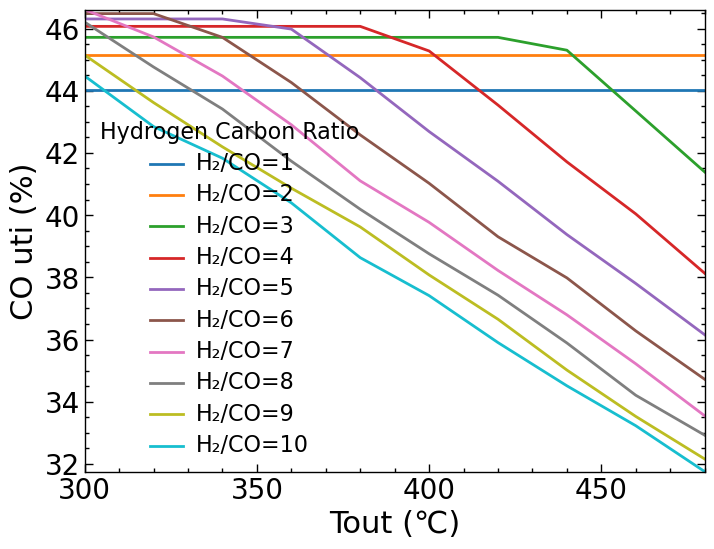

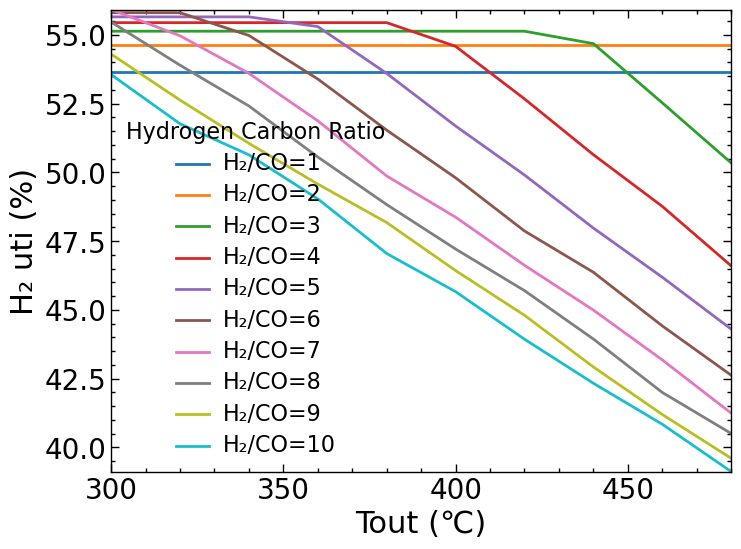

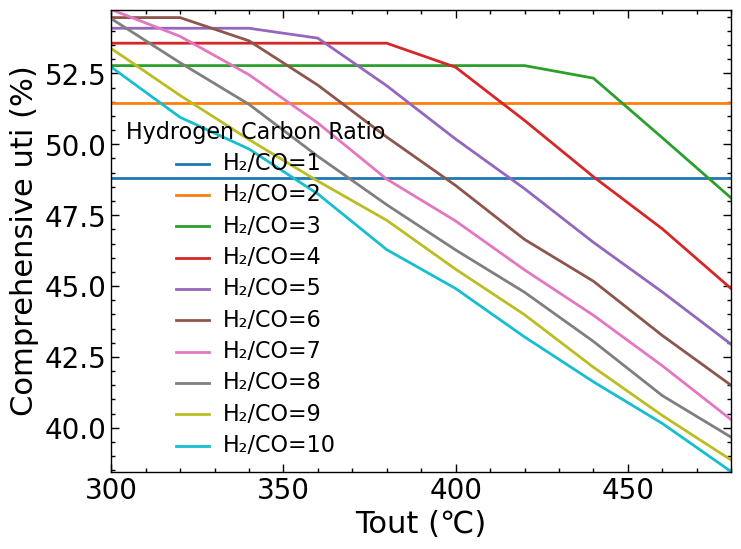

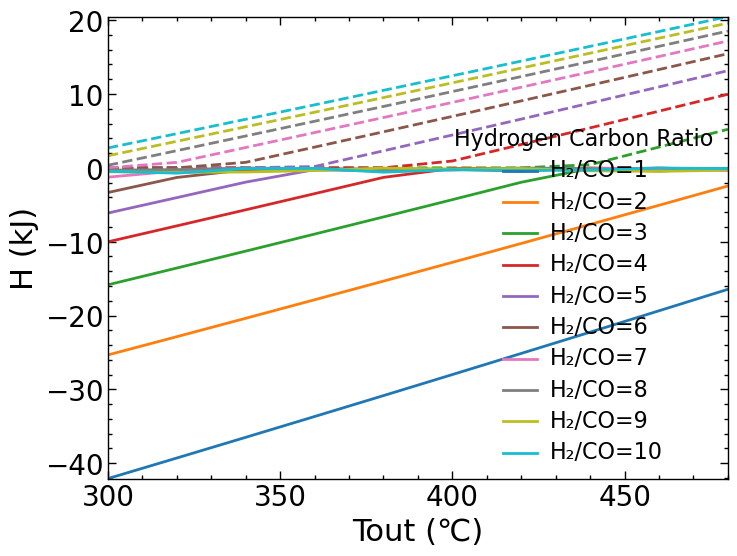

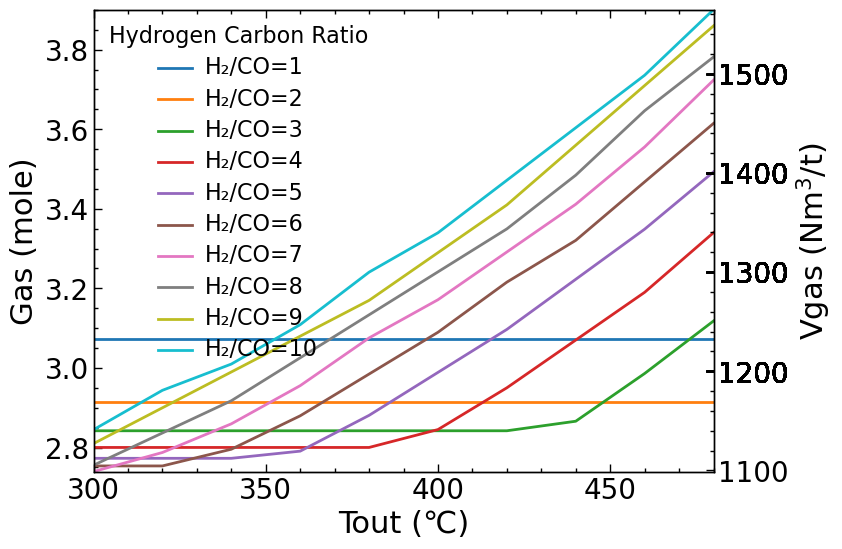

In [22]:
ratio=np.arange(300,500,20)
hydrogen_carbon_ratio_range = np.arange(1,11,1)
with plt.style.context(['science', 'notebook']):
    # Get built-in color cycle
    colors = cm.get_cmap('tab10', len(hydrogen_carbon_ratio_range))
    # Create the first plot (CO_uti vs hydrogen_carbon_ratio for Different T)
    fig1, ax1 = plt.subplots()

    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        CO_uti_values = [result_data_CO[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curve
        ax1.plot(ratio, np.array(CO_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    # Add legend, autoscale axis, and set axis properties
    legend = ax1.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax1.autoscale(tight=True)

    # Set axis properties
    ax1.set_xlabel('Tout (℃)',  fontsize=22)
    ax1.set_ylabel('CO uti (%)', fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size

    # Save the first plot as PDF and JPEG files
    fig1.savefig('figures5/fig_CO_Hydrogen_Carbon_Ratio.pdf')
    fig1.savefig('figures5/fig_CO_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    fig2, ax2 = plt.subplots()

    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        H2_uti_values = [result_data_H2[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curve
        ax2.plot(ratio, np.array(H2_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)

    # Add legend, autoscale axis, and set axis properties
    legend = ax2.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax2.autoscale(tight=True)
    
    # Set axis properties
    ax2.set_xlabel('Tout (℃)', fontsize=22)
    ax2.set_ylabel('H₂ uti (%)', fontsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size

    # Save the second plot as PDF and JPEG files
    fig2.savefig('figures5/fig_H2_Hydrogen_Carbon_Ratio.pdf')
    fig2.savefig('figures5/fig_H2_Hydrogen_Carbon_Ratio.jpg', dpi=1200) 
    
    fig3, ax3 = plt.subplots()
    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        Comprehensive_uti_values = [result_data_Comprehensive[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curve
        ax3.plot(ratio, np.array(Comprehensive_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)

    # Add legend, autoscale axis, and set axis properties
    legend = ax3.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax3.autoscale(tight=True)
    
    # Set axis properties
    ax3.set_xlabel('Tout (℃)', fontsize=22)
    ax3.set_ylabel('Comprehensive uti (%)', fontsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size

    # Save the third plot as PDF and JPEG files
    fig3.savefig('figures5/fig_Comprehensive_Hydrogen_Carbon_Ratio.pdf')
    fig3.savefig('figures5/fig_Comprehensive_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    fig4, ax4 = plt.subplots()
    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        H_values = [result_data_H[j][1][i] for j in range(len(ratio))]
        H_deficit_values = [result_data_Hdeficit[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curves
        ax4.plot(ratio, np.array(H_values) , label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
        ax4.plot(ratio, np.array(H_deficit_values),  color=color, linestyle='--')

    # Add legend, autoscale axis, and set axis properties
    legend = ax4.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax4.autoscale(tight=True)
    
    # Set axis properties
    ax4.set_xlabel('Tout (℃)', fontsize=22)
    ax4.set_ylabel('H (kJ)', fontsize=22)
    ax4.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size

    # Save the fourth plot as PDF and JPEG files
    fig4.savefig('figures5/fig_H_Hydrogen_Carbon_Ratio.pdf')
    fig4.savefig('figures5/fig_H_Hydrogen_Carbon_Ratio.jpg', dpi=1200)

    fig5, ax5 = plt.subplots()
    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        gasmole_values = [result_data_gasmole[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curve
        ax5.plot(ratio, np.array(gasmole_values), label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)

    # Add legend, autoscale axis, and set axis properties
    legend = ax5.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax5.autoscale(tight=True)
    fill_min, fill_max = ax5.get_ylim()
    # Set axis properties
    fill_min_converted = fill_min * 22.4 / (55.845 * 0.001)
    fill_max_converted = fill_max * 22.4 / (55.845 * 0.001)
    ax5_right = ax5.twinx()

    ax5_right.set_ylim(fill_min_converted, fill_max_converted)
    # Calculate tick values
    tick_values = np.ceil(np.linspace(fill_min_converted, fill_max_converted-100, 100) / 100) * 100
    # Set secondary axis ticks
    ax5_right.set_yticks(tick_values)
    ax5_right.set_ylabel('Vgas ($\mathrm{Nm}^3/\mathrm{t}$)', fontsize=22)
    # Set secondary axis tick labels
    tick_labels = [f'{int(value)}' for value in tick_values]
    ax5_right.set_yticklabels(tick_labels)
    ax5.set_xlabel('Tout (℃)', fontsize=22)
    ax5.set_ylabel('Gas (mole)', fontsize=22)
    ax5.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size
    ax5_right.tick_params(axis='y', which='major', labelsize=20)  # Set secondary axis tick label font size
    # Save the fifth plot as PDF and JPEG files
    fig5.savefig('figures5/fig_gasmole_Hydrogen_Carbon_Ratio.pdf')
    fig5.savefig('figures5/fig_gasmole_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    fig6, ax6 = plt.subplots()

    # Loop through the result data and plot the curves
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        energy_values = [result_data_energy[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        # Plot the curve
        ax6.plot(ratio, np.array(energy_values)/55.845, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)

    # Add legend, autoscale axis, and set axis properties
    legend = ax6.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16')  # Set legend title font size
    for label in legend.get_texts():
        label.set_fontsize('16')  # Set legend label font size
    ax6.autoscale(tight=True)
    
    # Set axis properties
    ax6.set_xlabel('Tout (℃)', fontsize=22)
    ax6.set_ylabel('Energy (MJ/t)', fontsize=22)
    ax6.tick_params(axis='both', which='major', labelsize=20)  # Set tick label font size

    # Save the sixth plot as PDF and JPEG files
    fig6.savefig('figures5/fig_energy_Hydrogen_Carbon_Ratio.pdf')
    fig6.savefig('figures5/fig_energy_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    plt.close()
    

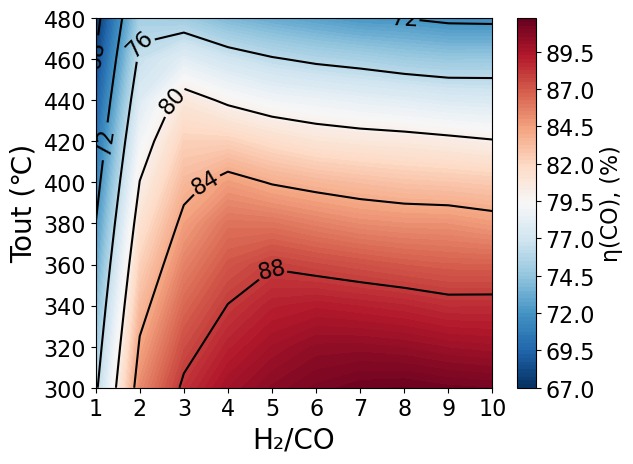

In [38]:
# Extract data
hydrogen_carbon_ratio_values = []
T_values = []
CO_uti_values = []

for data in result_data_CO:
    T = data[0]
    CO_uti_ratio_all = data[1]

    for i, hydrogen_carbon_ratio in enumerate(hydrogen_carbon_ratio_range):
        hydrogen_carbon_ratio_values.append(hydrogen_carbon_ratio)
        T_values.append(T)
        CO_uti_values.append(CO_uti_ratio_all[i]*100)

# Create grid, note the transposition here
X, Y = np.meshgrid(np.unique(hydrogen_carbon_ratio_values), np.unique(T_values))

# Convert CO_uti_values to appropriate shape
C = np.array(CO_uti_values, dtype=float).reshape(X.shape)


# Plot filled contour plot
contourf = plt.contourf(X, Y, C, 100, cmap='RdBu_r', zorder=1)

# Plot solid black contour lines
contour = plt.contour(X, Y, C, colors='black', linestyles='solid', linewidths=1.5, zorder=2)

# Add labels on contour lines
plt.clabel(contour, inline=True, fontsize=16)

# Set axis labels
plt.xlabel('H₂/CO', fontsize=20)
plt.ylabel('Tout (℃)', fontsize=20)
# Set tick label font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Contour Plot of CO_uti with Labels')

# Add color bar
cbar = plt.colorbar(contourf)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('η(CO), (%)', fontsize=16)

# Save the image
plt.savefig('figures5/contourf_plot_CO_uti_with_labels.pdf')
plt.savefig('figures5/contourf_plot_CO_uti_with_labels.jpg', dpi=1200, bbox_inches='tight')

# Show the image
plt.show()


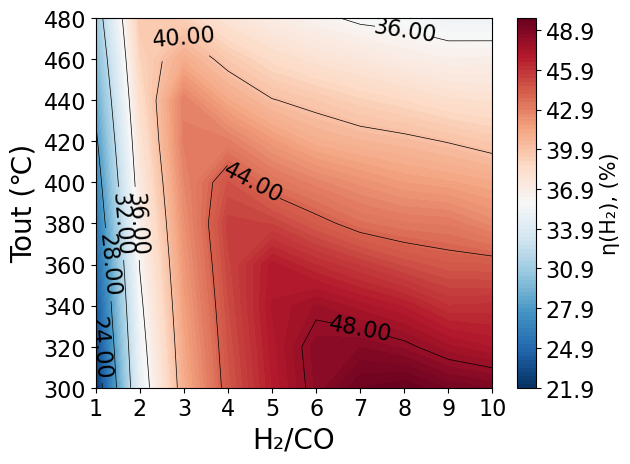

In [37]:
# Extract data
hydrogen_carbon_ratio_values = []
T_values = []
H2_uti_values = []

for data in result_data_H2:
    T = data[0]
    H2_uti_ratio_all = data[1]

    for i, hydrogen_carbon_ratio in enumerate(hydrogen_carbon_ratio_range):
        hydrogen_carbon_ratio_values.append(hydrogen_carbon_ratio)
        T_values.append(T)
        H2_uti_values.append(H2_uti_ratio_all[i]*100)

# Create grid, note the transposition here
X, Y = np.meshgrid(np.unique(hydrogen_carbon_ratio_values), np.unique(T_values))

# Convert H2_uti_values to appropriate shape
C = np.array(H2_uti_values, dtype=float).reshape(X.shape)

# Plot filled contour plot
contourf = plt.contourf(X, Y, C, 100, cmap='RdBu_r', zorder=1)

# Plot solid black contour lines
contour = plt.contour(X, Y, C, colors='black', linestyles='solid', linewidths=0.5, zorder=2)

# Add labels on contour lines
plt.clabel(contour, inline=True, fontsize=16, fmt='%1.2f')
# Set tick label font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Set axis labels
plt.xlabel('H₂/CO', fontsize=20)
plt.ylabel('Tout (℃)', fontsize=20)

#plt.title('Contour Plot of H2_uti with CO_uti Labels')

# Add color bar
cbar = plt.colorbar(contourf)
cbar.set_label('η(H₂), (%)', fontsize=15)
cbar.ax.tick_params(labelsize=16)
# Save the image
plt.savefig('figures5/contourf_plot_H2_uti_with_labels.pdf')
plt.savefig('figures5/contourf_plot_H2_uti_with_labels.jpg', dpi=1200, bbox_inches='tight')

# Show the image
plt.show()


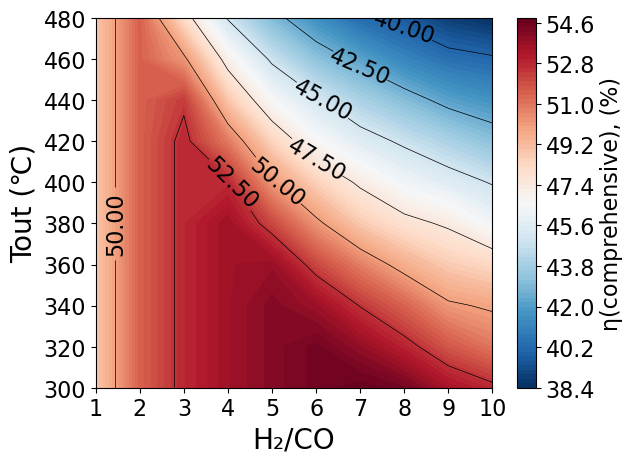

In [36]:

# 提取数据
hydrogen_carbon_ratio_values = []
T_values = []
Comprehensive_uti_values = []

for data in result_data_Comprehensive:
    T = data[0]
    Comprehensive_uti_ratio_all = data[1]

    for i, hydrogen_carbon_ratio in enumerate(hydrogen_carbon_ratio_range):
        hydrogen_carbon_ratio_values.append(hydrogen_carbon_ratio)
        T_values.append(T)
        Comprehensive_uti_values.append(Comprehensive_uti_ratio_all[i]*100)

# 创建网格，注意这里进行了转置
X, Y = np.meshgrid(np.unique(hydrogen_carbon_ratio_values), np.unique(T_values))

# 转换 H2_uti_values 为合适的形状
C = np.array(Comprehensive_uti_values, dtype=float).reshape(X.shape)

# 绘制填充颜色的等高线图
contourf = plt.contourf(X, Y, C, 100, cmap='RdBu_r', zorder=1)

# 绘制黑色实线的等高线
contour = plt.contour(X, Y, C, colors='black', linestyles='solid', linewidths=0.5, zorder=2)

# 在等高线上添加标签
plt.clabel(contour, inline=True, fontsize=16, fmt='%1.2f')

# 设置轴标签
plt.xlabel('H₂/CO', fontsize=20)
plt.ylabel('Tout (℃)', fontsize=20)
# 设置刻度标签的字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Contour Plot of Comprehensive_uti with CO_uti Labels')

# 添加颜色条
cbar = plt.colorbar(contourf)
cbar.set_label('η(comprehensive), (%)', fontsize=16)
cbar.ax.tick_params(labelsize=16)
# 保存图像
plt.savefig('figures5/contourf_plot_Comprehensive_uti_with_labels.pdf')
plt.savefig('figures5/contourf_plot_Comprehensive_uti_with_labels.jpg', dpi=1200, bbox_inches='tight')

# 显示图像
plt.show()